In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-z8rz45gk
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-z8rz45gk
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [1]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 22.82 MiB/s, done.


# Deep Learning with PyTorch : Siamese Network

*Author: Eda AYDIN*

# Siamese Network

![siamese-network.png](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*bJABur9wzFNACosQkim8kw.png)

[Eng]

A Siamese Network is a type of neural network architecture that is used for tasks that involve finding similarities or differences between two input samples. The network consists of two identical subnetworks that share the same set of weights and are trained simultaneously.

The basic idea behind a Siamese Network is to learn a similarity metric between two input samples. In other words, the network is trained to output a high value when the two input samples are similar and a low value when they are dissimilar. This makes it useful for a variety of applications, such as image or text similarity matching, face recognition, and signature verification.

One of main advantages of a Siamese Network is that it can be trained with very few examples, making it useful for applications where data is limited. Additionally, the shared weights between the two subnetworks allow the model to generalize well to new inputs.

Siamese Networks have been shown to be effective in a wide range of applications, including image recognition, classification, and speech recognition. They have also been applied to natural language processing tasks such as sentence similarity and paraphrase detection.


[Tr]

Siamese Network, iki giriş örneği arasındaki benzerlik ve farklılıkları bulmak için kullanılan bir sinir ağı mimarisidir. Ağ, iki aynı alt ağdan oluşur ve her biri aynı ağırlık kümesini paylaşır.

Siamese Network'ün temel fikri, iki giriş örneği arasındaki benzerliği öğrenmektir. Bu nedenle, ağ, iki giriş örneği benzer olduğunda yüksek bir çıktı değeri verir ve farklı olduğunda ise düşük bir çıktı değeri verir. Bu, örneğin görüntü veya metin benzerliği eşleştirme, yüz tanıma veya imza doğrulama gibi birçok uygulama için kullanışlıdır.

Siamese Network'ü kullanmanın en büyük avantajı, sınırlı veriyle bile eğitilebilmesidir. Ayrıca, alt ağlar arasındaki ağırlık paylaşımı, modelin yeni girişlere iyi genelleme yapabilmesine olanak tanır.

Siamese Network, görüntü tanıma, sınıflandırma ve konuşma tanıma gibi birçok alanda etkili olduğu kanıtlanmıştır. Ayrıca, cümle benzerliği ve paraphrase tespiti gibi doğal dil işleme görevleri için de uygulanabilir.

In [2]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

"""
Timm: PyTorch Image Models (timm) is a library for state-of-the-art-image classification, containing a collection of image models, optimizers, schedulers, augmentations and much more.
"""
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

"""
tqdm is a library that is used for creating Python Progress Bars. It gets its name from the Arabic name taqaddum, which means 'progress. '
"""
from tqdm import tqdm

# Configurations

In [4]:
DATA_DIR = "/content/Person-Re-Id-Dataset/train/"
CSV_FILE = "/content/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [5]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [6]:
row = df.iloc[11]



A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

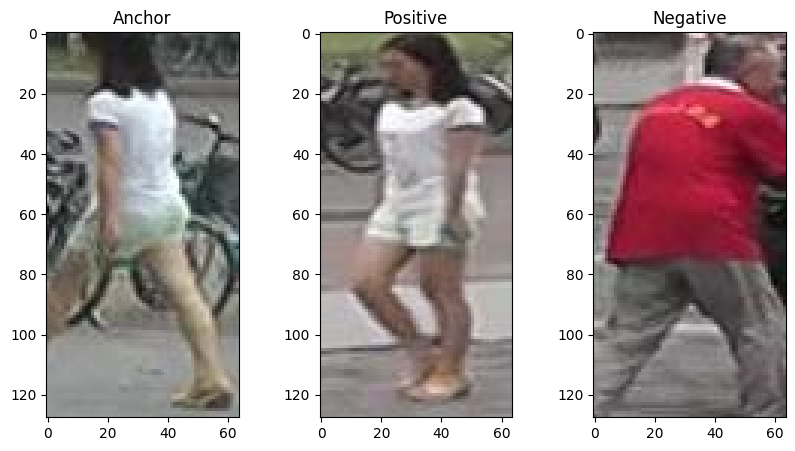

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [8]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create APN Dataset

In [22]:
class APN_Dataset(Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row.Anchor.lstrip('/'))
        P_img = io.imread(DATA_DIR + row.Positive.lstrip('/'))
        N_img = io.imread(DATA_DIR + row.Negative.lstrip('/'))

        A_img = torch.from_numpy(A_img).permute(2, 0 ,1).float() / 255.0
        P_img = torch.from_numpy(P_img).permute(2, 0 ,1).float() / 255.0
        N_img = torch.from_numpy(N_img).permute(2, 0 ,1).float() / 255.0


        return A_img, P_img, N_img

In [10]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


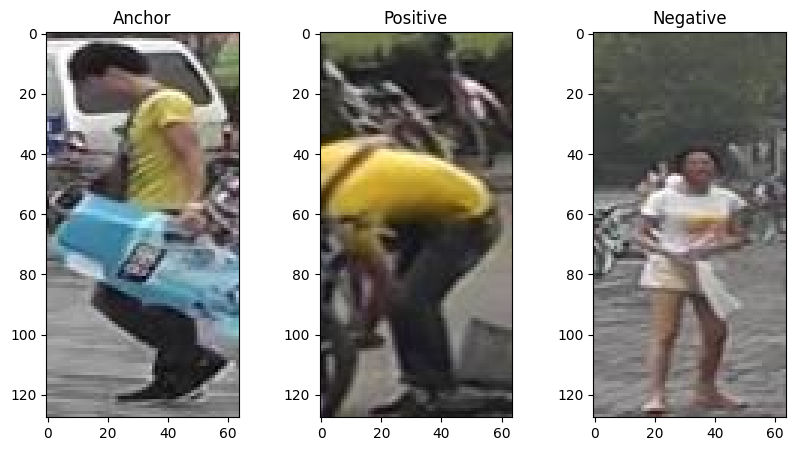

In [11]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [12]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE,shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [13]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [14]:
for A, P, N in trainloader:
    break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [15]:
class APN_Model(nn.Module):

    def __init__(self, emb_size = 512):
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features,
                                                out_features = emb_size)


    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

In [16]:
model = APN_Model()
model.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw):

# Create Train and Eval Function

In [17]:
def train_fn(model, dataloader, optimizer, criterion):
    model.train() # ON Dropout
    total_loss = 0.0

    for A,P,N in tqdm(dataloader):
        A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [18]:
def eval_fn(model, dataloader, criterion):
    model.eval()  # OFF Dropout
    total_loss = 0.0

    with torch.no_grad():
        for A,P,N in tqdm(dataloader):
            A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss += loss.item()

        return total_loss / len(dataloader)

In [19]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [21]:
best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = valid_loss
        print("SAVED_WEIGHT_SUCCESS")

    print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████| 25/25 [00:02<00:00,  9.47it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 1 train_loss: 0.5968920367956162 valid_loss: 0.5999924647808075


100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 2 train_loss: 0.28535742178559304 valid_loss: 0.3713403022289276


100%|██████████| 25/25 [00:02<00:00,  9.52it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 3 train_loss: 0.20957083165645599 valid_loss: 0.24891111195087434


100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 4 train_loss: 0.12201815888285637 valid_loss: 0.19391652703285217


100%|██████████| 25/25 [00:02<00:00,  8.99it/s]


EPOCHS: 5 train_loss: 0.04998568296432495 valid_loss: 0.2600224596261978


100%|██████████| 25/25 [00:02<00:00,  9.45it/s]


EPOCHS: 6 train_loss: 0.05846977993845939 valid_loss: 0.22203351736068724


100%|██████████| 25/25 [00:03<00:00,  8.16it/s]


EPOCHS: 7 train_loss: 0.048933724462985995 valid_loss: 0.24937967240810394


100%|██████████| 25/25 [00:03<00:00,  7.69it/s]


EPOCHS: 8 train_loss: 0.03886239975690842 valid_loss: 0.235456138253212


100%|██████████| 25/25 [00:02<00:00,  8.57it/s]


EPOCHS: 9 train_loss: 0.08804476633667946 valid_loss: 0.22347100734710693


100%|██████████| 25/25 [00:02<00:00,  9.31it/s]


EPOCHS: 10 train_loss: 0.0637633104622364 valid_loss: 0.24486860811710356


100%|██████████| 25/25 [00:02<00:00,  9.31it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 11 train_loss: 0.060202498137950894 valid_loss: 0.17849076211452483


100%|██████████| 25/25 [00:02<00:00,  9.39it/s]


EPOCHS: 12 train_loss: 0.03959650836884975 valid_loss: 0.18477850109338761


100%|██████████| 25/25 [00:02<00:00,  9.44it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 13 train_loss: 0.043007399737834934 valid_loss: 0.15608882516622544


100%|██████████| 25/25 [00:02<00:00,  9.48it/s]


EPOCHS: 14 train_loss: 0.04459821283817291 valid_loss: 0.1647336047887802


100%|██████████| 25/25 [00:02<00:00,  9.46it/s]

EPOCHS: 15 train_loss: 0.03372037291526794 valid_loss: 0.16118236005306244


# Get Anchor Embeddings

In [23]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
            A = A. to(DEVICE)
            A_enc = model(A.unsqueeze(0)) # c,h,w --> (1,c,h,w)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis=1)

    return df_enc

In [24]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])

100%|██████████| 4000/4000 [00:39<00:00, 102.42it/s]


In [25]:
df_enc.to_csv("database.csv", index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.097574,-0.954369,-0.182794,0.027208,-0.125852,0.503101,0.124485,-0.070726,0.448305,...,0.222875,-0.027530,0.566629,-0.213901,0.029048,-0.372850,0.113473,-0.213279,0.226505,-0.168285
1,1420_c3s3_061978_03.jpg,0.486710,-0.380687,0.537308,-0.057019,0.011432,-0.482536,-0.217785,0.853567,0.571782,...,0.161997,0.267804,0.754598,-0.409036,-0.816267,-0.340766,0.523915,0.118729,0.458763,-0.411372
2,1420_c5s3_062565_05.jpg,0.253942,-0.466870,0.413327,0.082666,-0.110762,-0.007089,-0.193079,0.289310,0.509252,...,0.073611,0.141204,0.583057,-0.258865,-0.455924,-0.179949,0.342560,-0.119927,0.244352,-0.416647
3,1420_c6s3_085592_04.jpg,0.075715,-0.909823,-0.236187,0.041461,-0.398664,0.284221,0.391392,0.349934,0.786012,...,0.117952,-0.143036,0.153306,-0.050953,-0.023516,-0.691329,0.295781,0.271483,0.110242,-0.260344
4,0663_c5s3_085987_03.jpg,-0.803267,0.394851,-0.741168,-0.882417,0.608843,0.168603,0.785402,-1.282467,-0.875355,...,-0.247408,0.154709,-0.040388,0.586934,1.597475,0.747324,-0.678871,0.251960,-0.341817,0.450174


# Inference

In [26]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [27]:
idx = 0
img_name = df_enc["Anchor"].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [28]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc["Anchor"]

In [29]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
    distance = np.append(distance, dist)

In [30]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.12/dist-packages/networkx/drawing/layout.py:982: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


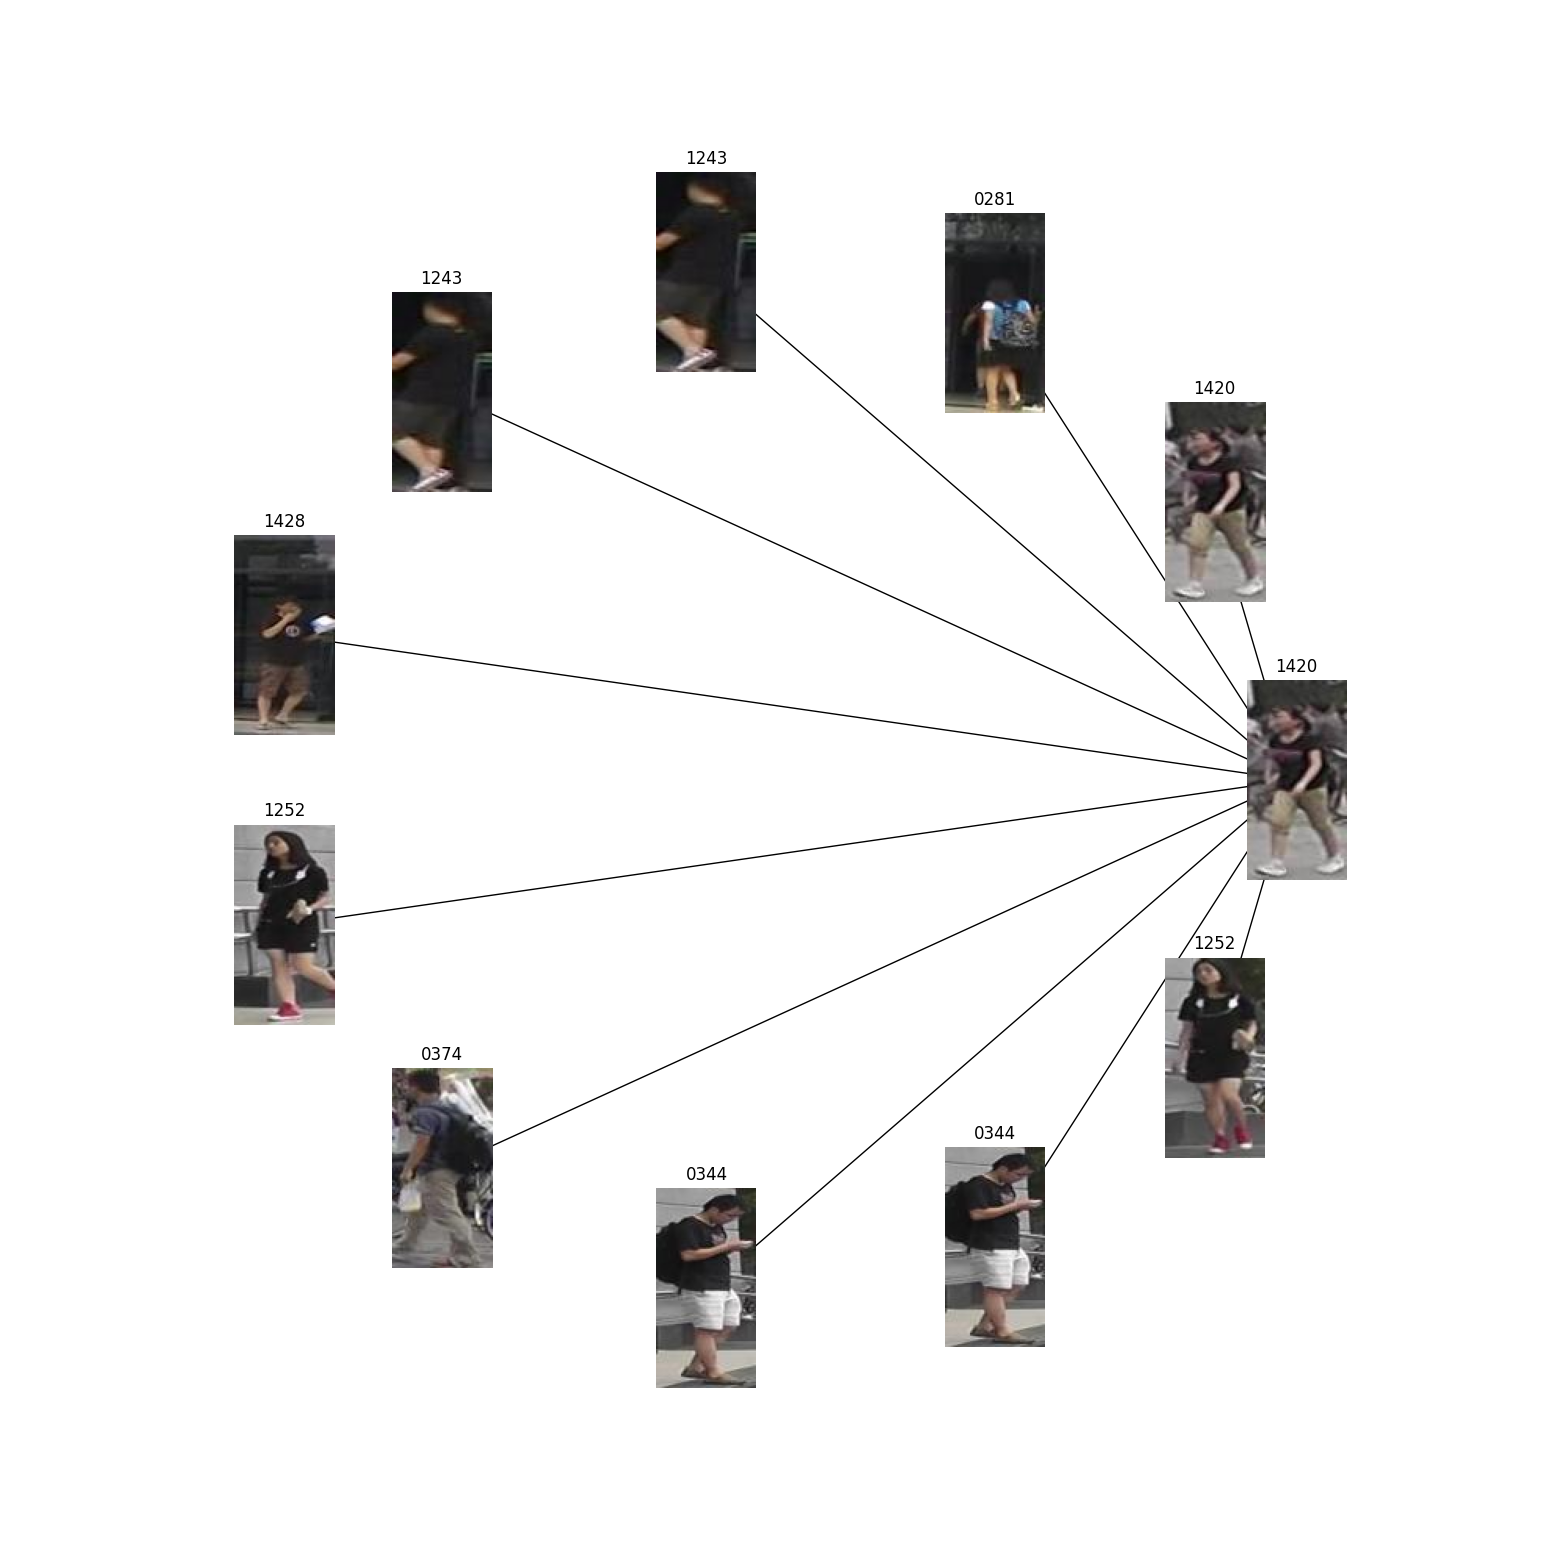

In [31]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);

# Resources

* [How to train your siamese neural network](https://towardsdatascience.com/how-to-train-your-siamese-neural-network-4c6da3259463)